In [3]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import keras
keras.utils.generic_utils = keras.utils
from tensorflow.keras.regularizers import l2
from segmentation_models import Unet
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
from tensorflow.keras import backend as K
import tensorflow as tf

In [4]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing

In [51]:
HEIGHT = 128
WIDTH = 128

In [6]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


model = Unet(BACKBONE, input_shape=(HEIGHT, WIDTH, 3), encoder_weights=None)


model.load_weights('/transfer/MasterProject/resnet34_imagenet_1000_no_top.h5', by_name=True)

2024-08-09 01:02:12.285313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 01:02:12.382830: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [52]:
for layer in model.layers:
    if 'resnet34' in layer.name:
        layer.trainable = False


from segmentation_models import Unet

import keras
keras.utils.generic_utils = keras.utils


model = Unet("resnet34", input_shape=(HEIGHT,WIDTH,3), encoder_weights="imagenet", encoder_freeze=False)


In [53]:
def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [54]:
def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img


def preprocess_image(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  image = image[:, 21:149].astype("float")
  # image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map = imutils.resize(depth_map, height=HEIGHT)
  depth_map = depth_map[:, 21:149].astype("float")
  # depth_map = depth_map.astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [55]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
        X = self.__data_generation(list_IDs_temp)
        print(f"Batch {index} - X shape: {X.shape}")
        return X
    X, y = self.__data_generation(list_IDs_temp)
    print(f"Batch {index} - X shape: {X.shape}, y shape: {y.shape}")
    return X, y


  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [56]:
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "data/nyu2_train.csv"
TEST_PATH = "data/nyu2_test.csv"

In [57]:
partition, labels = load_train_paths(TRAIN_PATH)
print(len(partition['train']), len(partition['validation']))

training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)


22437 9617


In [58]:
opt = Adam(learning_rate=INIT_LR, amsgrad=True)

def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 3.0, 0.1
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))



def depth_acc(y_true, y_pred):
  y_true = K.cast(y_true, 'float32')
  y_pred = K.cast(y_pred, 'float32')

  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [59]:
def save_checkpoint(model, checkpoint_path):
    model.save_weights(checkpoint_path)
    print(f"Model weights saved to {checkpoint_path}")

In [1]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])


r = model.fit(training_generator, validation_data=validation_generator, epochs=5)




2024-07-24 20:50:08.979271: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 20:50:09.498847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 20:50:12.596682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 20:50:12.607012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 20:50:28.006667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Segmentation Models: using `keras` framework.


2024-07-24 20:51:09.079471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 20:51:09.175132: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


22437 9617
Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Epoch 1/5
Batch 53 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 828 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 437 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
 102/1402 [=>............................] - ETA: 6:40 - loss: 0.4051 - depth_acc: 0.5543Batch 640 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 206/1402 [===>..........................] - ETA: 6:21 - loss: 0.3585 - depth_acc: 0.5780Batch 829 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 310/1402 [=====>........................] - ETA: 5:53 - loss: 0.3418 - depth_acc: 0.5916Batch 1160 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 414/1402 [=======>......................] - ETA: 5:22 - loss: 0.3310 - depth_acc: 0.6063Batch 1041 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 518/1402 [==========>...................] - ETA: 4:51 - loss: 0.3203 - depth_acc: 0.6311Batch 449 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 622/1402 [============>.................] - ETA: 4:18 - loss: 0.3103 - depth_acc: 0.6546Batch 715 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 726/1402 [==============>...............] - ETA: 3:44 - loss: 0.3014 - depth_acc: 0.6759Batch 266 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 830/1402 [================>.............] - ETA: 3:10 - loss: 0.2931 - depth_acc: 0.6941Batch 202 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 934/1402 [==================>...........] - ETA: 2:36 - loss: 0.2863 - depth_acc: 0.7088Batch 1226 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1038/1402 [=====================>........] - ETA: 2:01 - loss: 0.2802 - depth_acc: 0.7223Batch 537 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1142/1402 [=======================>......] - ETA: 1:27 - loss: 0.2747 - depth_acc: 0.7336Batch 14 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1246/1402 [=========================>....] - ETA: 52s - loss: 0.2699 - depth_acc: 0.7436Batch 148 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1299/1402 [==========================>...] - ETA: 34s - loss: 0.2676 - depth_acc: 0.7480Batch 864 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1352/1402 [===========================>..] - ETA: 16s - loss: 0.2654 - depth_acc: 0.7524Batch 397 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1402/1402 [==============================] - ETA: 0s - loss: 0.2633 - depth_acc: 0.7563Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 1 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 2 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 3 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 4 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 5 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 6 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 7 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 8 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 10 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 11 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


Batch 12 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 13 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 14 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 15 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 16 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 17 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 18 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 19 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 20 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 21 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 22 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 23 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 24 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 25 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 26 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 27 -

Batch 136 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 137 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 138 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 139 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 140 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 141 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 142 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 143 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 144 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 145 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 146 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 147 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 148 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 149 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 150 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 260 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 261 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 262 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 263 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 264 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 265 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 266 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 267 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 268 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 269 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 270 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 271 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 272 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 273 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 274 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 384 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 385 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 386 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 387 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 388 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 389 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 390 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 391 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 392 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 393 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 394 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 395 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 396 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 397 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 398 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 508 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 509 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 510 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 511 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 512 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 513 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 514 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 515 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 516 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 517 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 518 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 519 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 520 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 521 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 522 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

 166/1402 [==>...........................] - ETA: 6:51 - loss: 0.2068 - depth_acc: 0.8698Batch 664 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 270/1402 [====>.........................] - ETA: 6:16 - loss: 0.2053 - depth_acc: 0.8696Batch 315 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 374/1402 [=======>......................] - ETA: 5:41 - loss: 0.2046 - depth_acc: 0.8709Batch 881 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 478/1402 [=========>....................] - ETA: 5:07 - loss: 0.2039 - depth_acc: 0.8717Batch 183 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 582/1402 [===========>..................] - ETA: 4:32 - loss: 0.2029 - depth_acc: 0.8736Batch 1137 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 686/1402 [=============>................] - ETA: 3:58 - loss: 0.2021 - depth_acc: 0.8748Batch 963 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 790/1402 [===============>..............] - ETA: 3:23 - loss: 0.2009 - depth_acc: 0.8759Batch 45 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 894/1402 [==================>...........] - ETA: 2:48 - loss: 0.2002 - depth_acc: 0.8767Batch 293 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 998/1402 [====================>.........] - ETA: 2:14 - loss: 0.1990 - depth_acc: 0.8781Batch 1111 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1102/1402 [======================>.......] - ETA: 1:39 - loss: 0.1979 - depth_acc: 0.8794Batch 1053 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1206/1402 [========================>.....] - ETA: 1:05 - loss: 0.1972 - depth_acc: 0.8801Batch 1110 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1259/1402 [=========================>....] - ETA: 47s - loss: 0.1969 - depth_acc: 0.8805Batch 517 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1312/1402 [===========================>..] - ETA: 29s - loss: 0.1965 - depth_acc: 0.8809Batch 322 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1365/1402 [============================>.] - ETA: 12s - loss: 0.1962 - depth_acc: 0.8813Batch 1021 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1402/1402 [==============================] - ETA: 0s - loss: 0.1959 - depth_acc: 0.8816Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 1 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 2 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 3 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 4 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 5 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 6 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 7 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 8 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 10 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 11 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 12 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 13 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)

Batch 44 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 45 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 46 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 47 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 48 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 49 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 50 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 51 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 52 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 53 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 54 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 55 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 56 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 57 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 58 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 59 -

Batch 168 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 169 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 170 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 171 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 172 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 173 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 174 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 175 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 176 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 177 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 178 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 179 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 180 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 181 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 182 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 291 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 292 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 293 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 294 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 295 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 296 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 297 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 298 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 299 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 300 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 301 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 302 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 303 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 304 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 305 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 414 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 415 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 416 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 417 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 418 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 419 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 420 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 421 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 422 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 423 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 424 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 425 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 426 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 427 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 428 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 537 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 538 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 539 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 540 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 541 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 542 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 543 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 544 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 545 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 546 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 547 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 548 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 549 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 550 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 551 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

 127/1402 [=>............................] - ETA: 7:05 - loss: 0.1829 - depth_acc: 0.8973Batch 1138 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 231/1402 [===>..........................] - ETA: 6:30 - loss: 0.1827 - depth_acc: 0.8959Batch 1310 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 335/1402 [======>.......................] - ETA: 5:55 - loss: 0.1827 - depth_acc: 0.8966Batch 1018 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 439/1402 [========>.....................] - ETA: 5:20 - loss: 0.1821 - depth_acc: 0.8970Batch 1360 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 543/1402 [==========>...................] - ETA: 4:45 - loss: 0.1818 - depth_acc: 0.8976Batch 915 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 647/1402 [============>.................] - ETA: 4:11 - loss: 0.1814 - depth_acc: 0.8979Batch 498 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 751/1402 [===============>..............] - ETA: 3:36 - loss: 0.1805 - depth_acc: 0.8985Batch 157 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 855/1402 [=================>............] - ETA: 3:02 - loss: 0.1801 - depth_acc: 0.8989Batch 231 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 959/1402 [===================>..........] - ETA: 2:27 - loss: 0.1798 - depth_acc: 0.8988Batch 356 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1063/1402 [=====================>........] - ETA: 1:52 - loss: 0.1793 - depth_acc: 0.8997Batch 1292 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1167/1402 [=======================>......] - ETA: 1:18 - loss: 0.1790 - depth_acc: 0.9003Batch 1283 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1272/1402 [==========================>...] - ETA: 43s - loss: 0.1786 - depth_acc: 0.9009Batch 1382 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1325/1402 [===========================>..] - ETA: 25s - loss: 0.1784 - depth_acc: 0.9011Batch 1066 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1378/1402 [============================>.] - ETA: 7s - loss: 0.1782 - depth_acc: 0.9012Batch 1010 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1402/1402 [==============================] - ETA: 0s - loss: 0.1782 - depth_acc: 0.9011Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 1 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 2 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 3 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 4 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 5 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 6 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 7 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 8 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 10 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 11 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 12 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 13 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)

Batch 74 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 75 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 76 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 77 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 78 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 79 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 80 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 81 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 82 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 83 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 84 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 85 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 86 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 87 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 88 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 89 -

Batch 197 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 198 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 199 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 200 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 201 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 202 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 203 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 204 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 205 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 206 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 207 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 208 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 209 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 210 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 211 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 320 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 321 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 322 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 323 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 324 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 325 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 326 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 327 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 328 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 329 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 330 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 331 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 332 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 333 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 334 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 443 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 444 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 445 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 446 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 447 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 448 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 449 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 450 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 451 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 452 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 453 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 454 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 455 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 456 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 457 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 566 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 567 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 568 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 569 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 570 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 571 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 572 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 573 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 574 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 575 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 576 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 577 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 578 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 579 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 580 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

 191/1402 [===>..........................] - ETA: 6:42 - loss: 0.1696 - depth_acc: 0.9083Batch 382 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 295/1402 [=====>........................] - ETA: 6:08 - loss: 0.1698 - depth_acc: 0.9084Batch 719 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 399/1402 [=======>......................] - ETA: 5:33 - loss: 0.1688 - depth_acc: 0.9092Batch 1042 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 503/1402 [=========>....................] - ETA: 4:59 - loss: 0.1686 - depth_acc: 0.9102Batch 297 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 607/1402 [===========>..................] - ETA: 4:24 - loss: 0.1683 - depth_acc: 0.9109Batch 639 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 711/1402 [==============>...............] - ETA: 3:49 - loss: 0.1681 - depth_acc: 0.9104Batch 94 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 815/1402 [================>.............] - ETA: 3:15 - loss: 0.1678 - depth_acc: 0.9108Batch 898 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 919/1402 [==================>...........] - ETA: 2:40 - loss: 0.1676 - depth_acc: 0.9106Batch 24 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1023/1402 [====================>.........] - ETA: 2:05 - loss: 0.1676 - depth_acc: 0.9111Batch 1287 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1127/1402 [=======================>......] - ETA: 1:31 - loss: 0.1675 - depth_acc: 0.9112Batch 253 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1231/1402 [=========================>....] - ETA: 56s - loss: 0.1670 - depth_acc: 0.9118Batch 1342 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1284/1402 [==========================>...] - ETA: 39s - loss: 0.1669 - depth_acc: 0.9119Batch 921 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1337/1402 [===========================>..] - ETA: 21s - loss: 0.1667 - depth_acc: 0.9120Batch 1031 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1390/1402 [============================>.] - ETA: 3s - loss: 0.1666 - depth_acc: 0.9119Batch 493 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1402/1402 [==============================] - ETA: 0s - loss: 0.1666 - depth_acc: 0.9119Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 1 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 2 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 3 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 4 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 5 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 6 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 7 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 8 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 10 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 11 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 12 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 13 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)

Batch 102 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 103 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 104 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 105 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 106 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 107 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 108 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 109 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 110 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 111 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 112 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 113 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 114 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 115 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 116 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 225 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 226 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 227 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 228 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 229 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 230 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 231 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 232 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 233 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 234 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 235 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 236 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 237 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 238 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 239 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 348 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 349 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 350 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 351 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 352 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 353 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 354 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 355 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 356 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 357 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 358 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 359 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 360 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 361 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 362 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 471 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 472 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 473 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 474 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 475 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 476 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 477 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 478 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 479 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 480 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 481 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 482 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 483 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 484 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 485 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 594 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 595 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 596 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 597 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 598 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 599 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 600 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
1402/1402 [==============================] - 536s 383ms/step - loss: 0.1666 - depth_acc: 0.9119 - val_loss: 0.1632 - val_depth_acc: 0.9228
Epoch 5/5
Batch 1140 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 287 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
   1/1402 [..............................] - ETA: 9:37 - loss: 0.1583 - depth_acc: 0.8976Batch 1256 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 429 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
  99/1402 [=>..........

 203/1402 [===>..........................] - ETA: 6:38 - loss: 0.1601 - depth_acc: 0.9201Batch 1310 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 307/1402 [=====>........................] - ETA: 6:03 - loss: 0.1601 - depth_acc: 0.9184Batch 1307 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 411/1402 [=======>......................] - ETA: 5:28 - loss: 0.1598 - depth_acc: 0.9184Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 515/1402 [==========>...................] - ETA: 4:54 - loss: 0.1597 - depth_acc: 0.9179Batch 259 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 619/1402 [============>.................] - ETA: 4:19 - loss: 0.1595 - depth_acc: 0.9187Batch 1013 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 723/1402 [==============>...............] - ETA: 3:45 - loss: 0.1591 - depth_acc: 0.9192Batch 533 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 827/1402 [================>.............] - ETA: 3:10 - loss: 0.1590 - depth_acc: 0.9192Batch 590 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


 931/1402 [==================>...........] - ETA: 2:36 - loss: 0.1588 - depth_acc: 0.9194Batch 1015 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1035/1402 [=====================>........] - ETA: 2:01 - loss: 0.1586 - depth_acc: 0.9198Batch 1291 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1139/1402 [=======================>......] - ETA: 1:27 - loss: 0.1584 - depth_acc: 0.9201Batch 762 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1244/1402 [=========================>....] - ETA: 52s - loss: 0.1583 - depth_acc: 0.9200Batch 1020 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1297/1402 [==========================>...] - ETA: 34s - loss: 0.1580 - depth_acc: 0.9201Batch 240 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1350/1402 [===========================>..] - ETA: 17s - loss: 0.1578 - depth_acc: 0.9204Batch 631 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


1402/1402 [==============================] - ETA: 0s - loss: 0.1577 - depth_acc: 0.9203Batch 0 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 1 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 2 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 3 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 4 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 5 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 6 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 7 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 8 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)


Batch 9 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 10 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 11 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 12 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 13 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 14 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 15 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 16 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 17 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 18 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 19 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 20 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 21 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 22 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 23 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 24 - 

Batch 133 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 134 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 135 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 136 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 137 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 138 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 139 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 140 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 141 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 142 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 143 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 144 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 145 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 146 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 147 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 256 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 257 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 258 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 259 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 260 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 261 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 262 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 263 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 264 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 265 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 266 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 267 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 268 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 269 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 270 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 379 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 380 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 381 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 382 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 383 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 384 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 385 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 386 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 387 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 388 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 389 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 390 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 391 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 392 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 393 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

Batch 502 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 503 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 504 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 505 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 506 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 507 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 508 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 509 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 510 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 511 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 512 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 513 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 514 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 515 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128, 1)
Batch 516 - X shape: (16, 128, 128, 3), y shape: (16, 128, 128

In [2]:
checkpoint_path = "checkpoints/final_model.h5"
save_checkpoint(model, checkpoint_path)


Model weights saved to checkpoints/final_model.h5


In [60]:
def load_checkpoint(checkpoint_path, model):
    model.load_weights(checkpoint_path)
    print(f"Model weights loaded from {checkpoint_path}")
    return model

In [61]:
checkpoint_path = "checkpoints/final_model.h5"
model = load_checkpoint(checkpoint_path, model)

Model weights loaded from checkpoints/final_model.h5


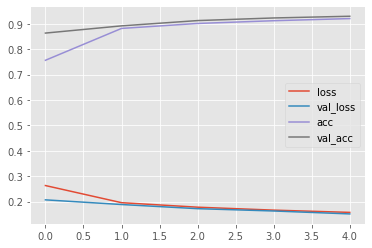

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [62]:
img_dm_pairs = read_csv('./data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

654


In [63]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [64]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

21/21 [==============================] - 3s 130ms/step


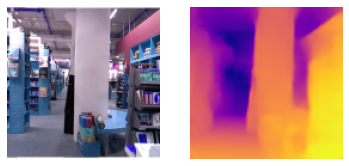

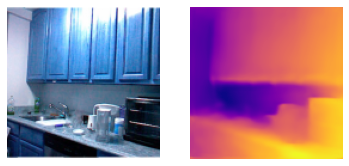

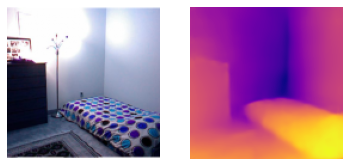

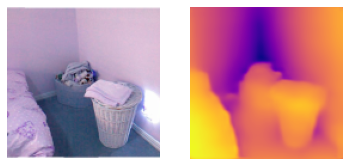

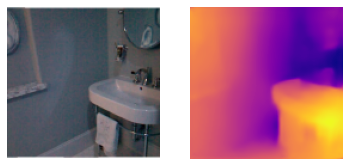

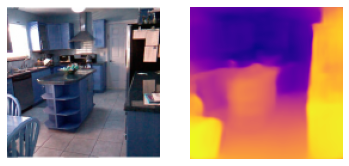

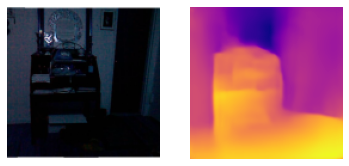

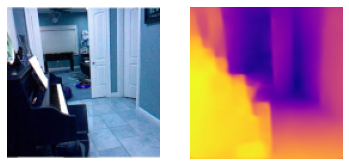

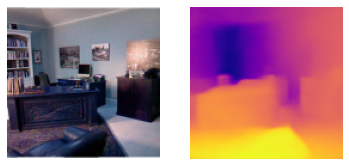

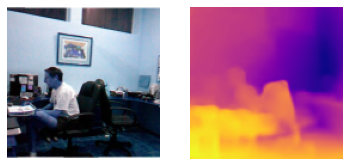

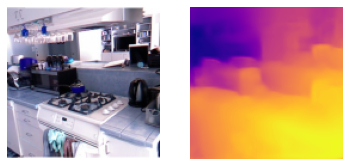

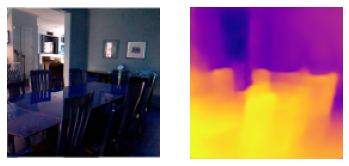

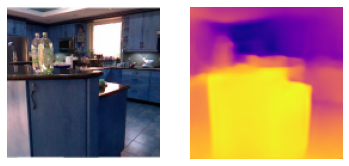

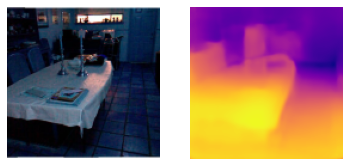

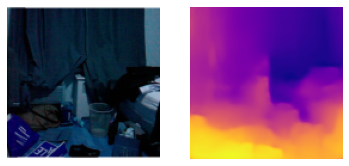

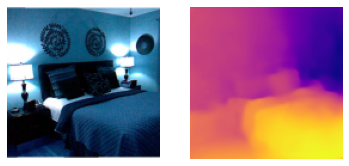

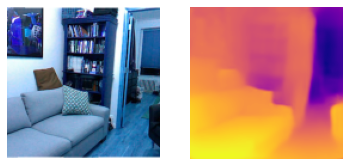

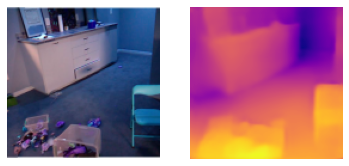

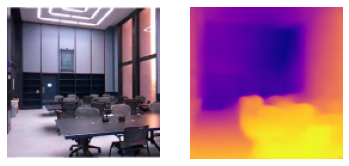

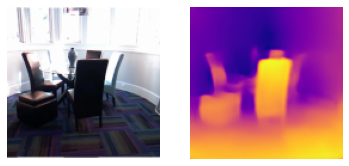

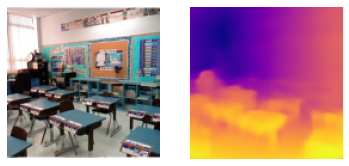

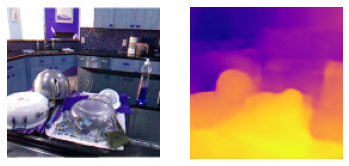

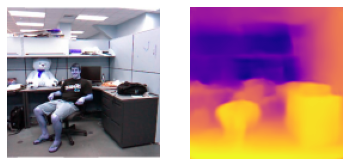

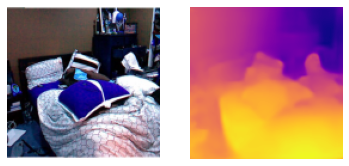

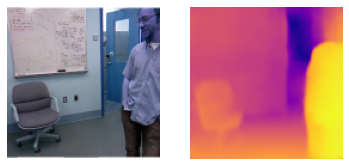

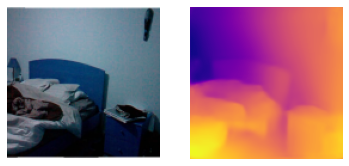

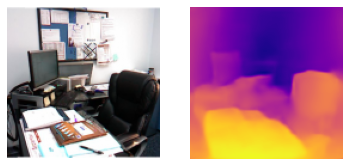

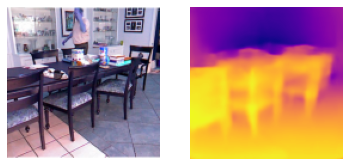

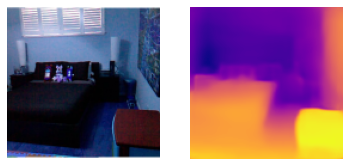

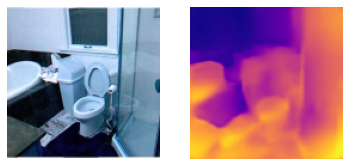

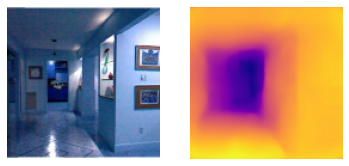

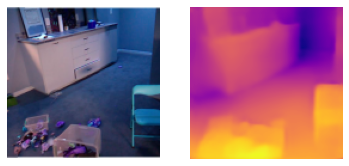

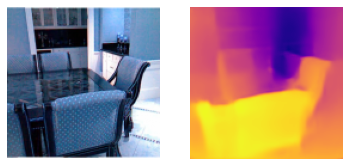

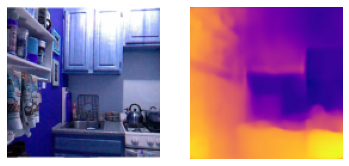

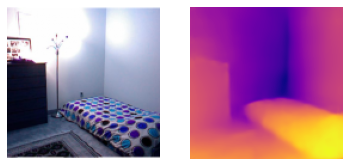

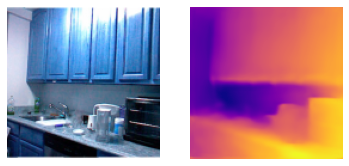

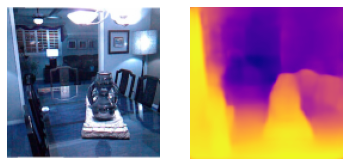

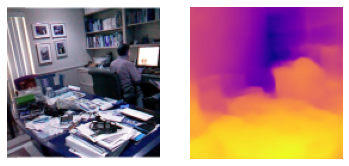

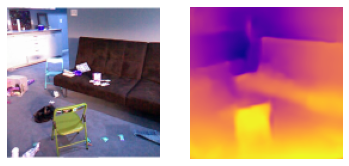

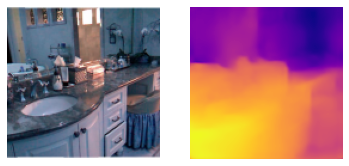

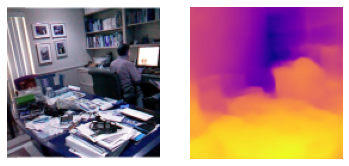

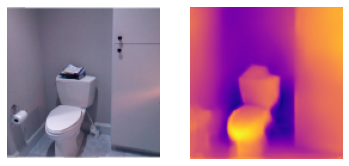

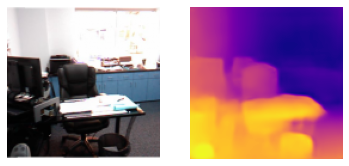

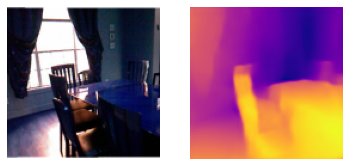

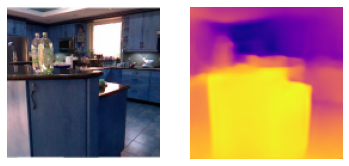

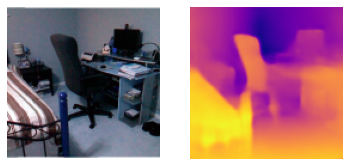

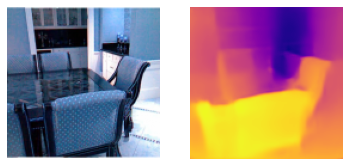

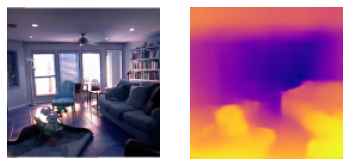

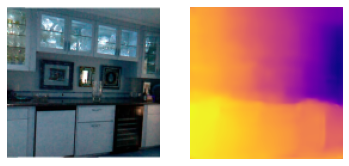

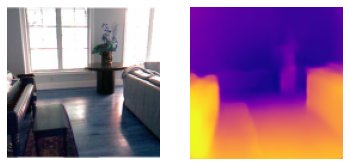

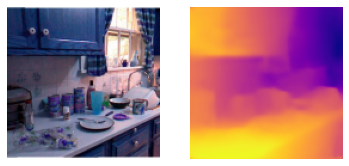

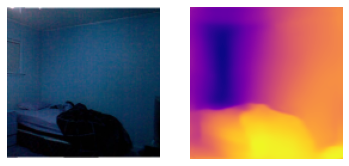

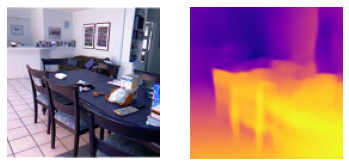

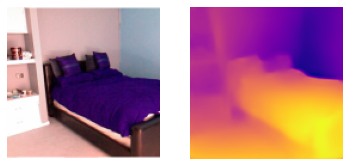

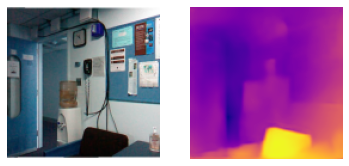

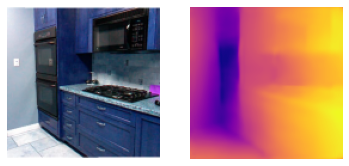

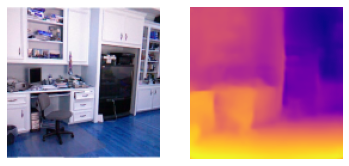

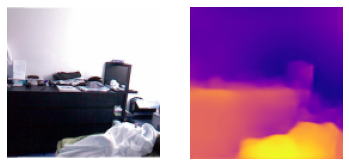

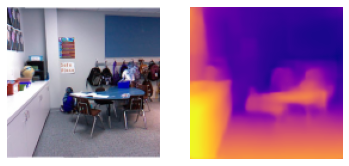

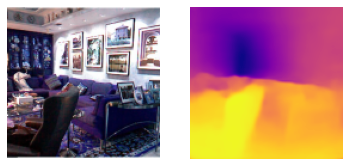

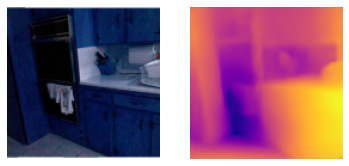

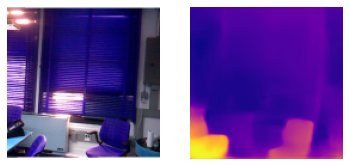

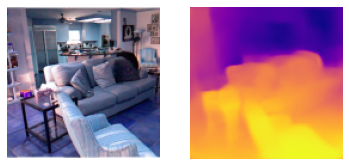

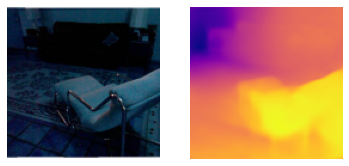

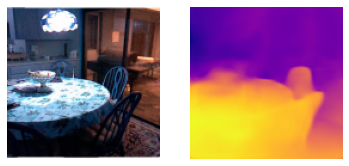

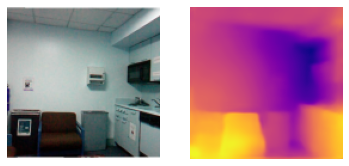

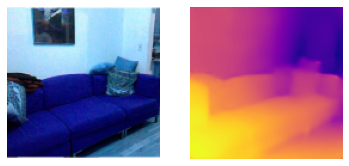

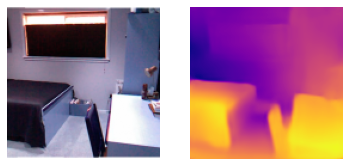

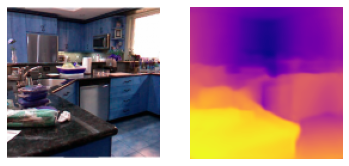

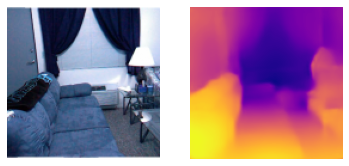

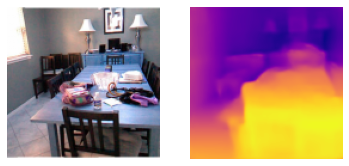

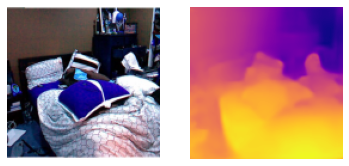

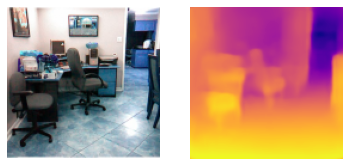

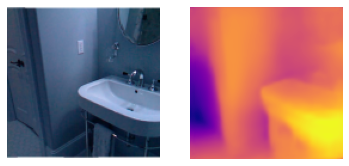

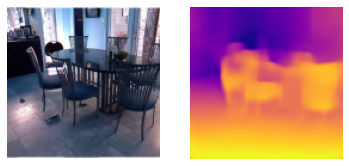

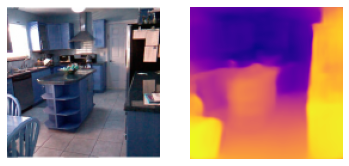

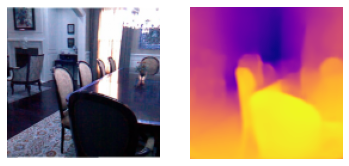

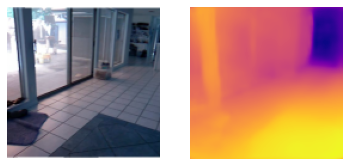

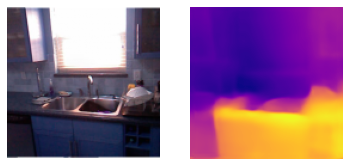

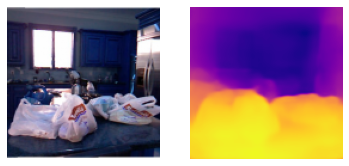

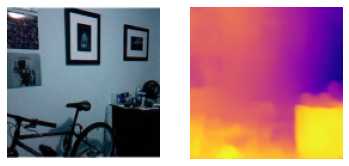

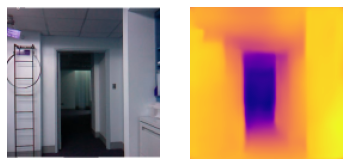

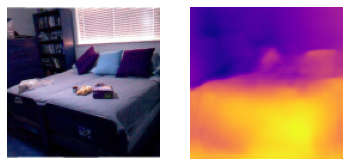

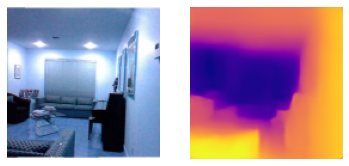

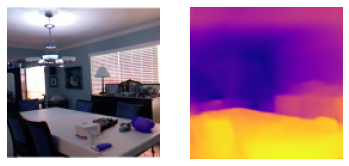

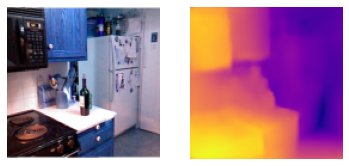

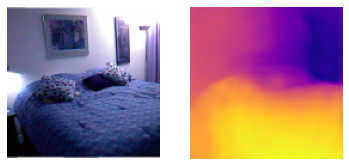

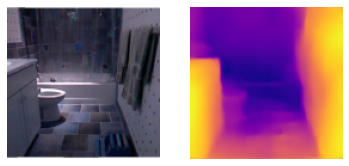

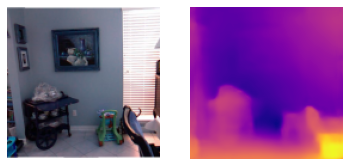

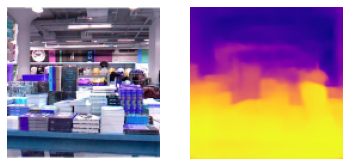

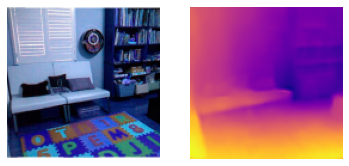

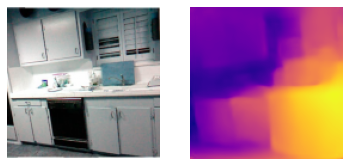

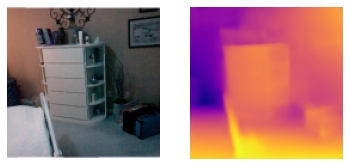

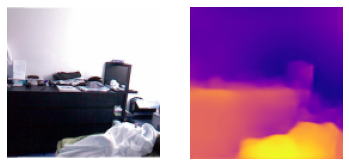

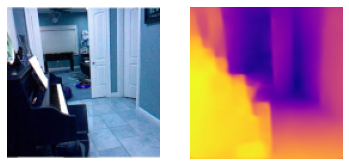

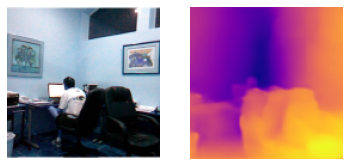

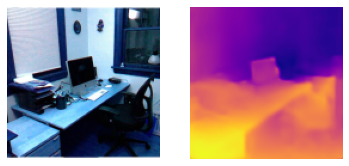

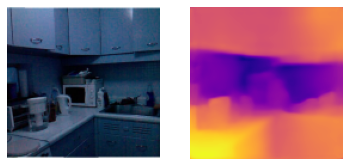

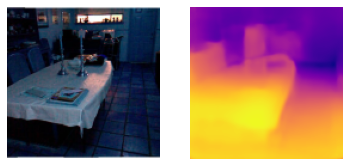

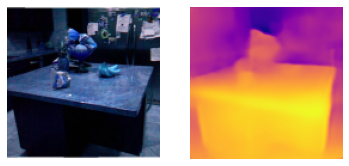

In [65]:
indices = np.random.randint(0, len(test_paths), 100)
cmap = "plasma_r"

for i in indices:
    path = partition['test'][i]
    label_path = labels[path]
    pred = preds[i]
    pred = np.squeeze(pred, axis=-1)

    plt.subplot(1, 2, 1)
    plt.axis("off")
    img1 = preprocess_image(path, horizontal_flip=False)
    plt.imshow(img1)

    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(pred, cmap=plt.get_cmap(cmap))

    plt.show()


In [66]:
test_img_path = '/transfer/MasterProject/test_img/2.jpg'
test_image_ori = cv2.imread(test_img_path)
print(test_image_ori.shape)

(723, 736, 3)


In [67]:
import cv2
import numpy as np

def preprocess_image_new(img_path):
    image = cv2.imread(img_path)
    
    if image is None:
        raise ValueError(f"error: {img_path}")
    
    h, w = image.shape[:2]
    
    max_dim = max(h, w)
    
    new_image = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)
    
    if h > w:
        padding = (h - w) // 2
        new_image[:, padding:padding+w] = image
    else:
        padding = (w - h) // 2
        new_image[padding:padding+h, :] = image
    
    return new_image



In [68]:
test_image_p = preprocess_image_new(test_img_path)

In [69]:
test_image_p.shape

(736, 736, 3)

In [70]:
image_1_bgr = cv2.cvtColor(test_image_p, cv2.COLOR_RGB2BGR)

save_path = '/transfer/MasterProject/test_img/2_processed.png'

cv2.imwrite(save_path, image_1_bgr)
print(f"Save to: {save_path}")

Save to: /transfer/MasterProject/test_img/2_processed.png


In [71]:
def preprocess_image_reduce(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

In [72]:
image_1_test = np.empty((1, 128, 128, 3))
image_1_test[0, ] = preprocess_image_reduce(save_path, horizontal_flip=False)


1/1 [==============================] - 0s 20ms/step


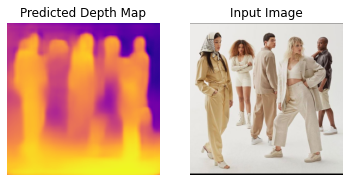

In [73]:
pred_single = model.predict(image_1_test)
pred_single = np.squeeze(pred_single, axis=0)  

cmap = "plasma_r"

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Predicted Depth Map")
plt.imshow(pred_single, cmap=plt.get_cmap(cmap))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Input Image")
image_1_test_ori = cv2.imread(save_path)
plt.imshow(image_1_test_ori)

plt.show()